In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from KMeansMissing import kmeans_missing

In [26]:
sacog_wDemo = pd.read_csv('../data/rMoves_and_2020_matchLabel.csv')
sacog_wDemo = sacog_wDemo.iloc[2838:,:]
sacog = pd.read_excel('../data/manipulatedData/sacog_with_new_variables.xlsx')
sacog = sacog[sacog.iloc[:,0].isin(sacog_wDemo.match_id)]

In [27]:
demo = ['match_id', 'PersonalIncome', 
        'Children-12To18', 'Children-5To12', 'Children-Under5','What is your age group?',
        'May-Employment', 'May-Employment-Industry', 'HouseholdIncome', 'Gender',
        'ethnicity_afam',
        'ethnicity_aiak',
        'ethnicity_asian',
        'ethnicity_hapi',
        'ethnicity_hisp',
        'ethnicity_mideast',
        'ethnicity_multi',
        'ethnicity_noanswer',
        'ethnicity_other',
        'ethnicity_white',
        'Disability-Chronic',
        'Disability-Developmental',
        'Disability-Hearing',
        'Disability-MentalHealth',
        'Disability-None',
        'Disability-Other',
        'Disability-Physical',
        'Disability-Vision',
        'hhveh',
       'numkids']

In [28]:
sacog_wDemo = sacog_wDemo[demo]

In [29]:
changeType = ['match_id', 'Children-12To18', 'Children-5To12', 'Children-Under5', 'Disability-Chronic',
           'Disability-Developmental',
           'Disability-Hearing',
           'Disability-MentalHealth',
           'Disability-None',
           'Disability-Other',
           'Disability-Physical',
           'Disability-Vision'] 
sacog_wDemo[changeType] = sacog_wDemo[changeType].astype('int64')

In [30]:
sacog_demo = pd.merge(sacog_wDemo, sacog, left_on = 'match_id', right_on = 'id')

In [31]:
sacog_demo.rename(columns = {'What is your age group?': 'age'}, inplace = True)
sacog_demo[['Children-12To18', 'Children-5To12', 'Children-Under5']].replace(-9998, 0, inplace = True)

/Users/apple/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)


### Clustering Analysis
#### 1) Clustering by Portion of Online Shopping

In [8]:
# Ordered by the mean of portion of online shopping, high to low
cat = ['ChildcareItems', 'Clothing', 'Medication', 'HomeOffice', 'PreparedFood', 'OtherFood', 'PaperCleaning', 'Groceries' ]

In [90]:
len(subset)

21

In [9]:
# subset is for initialization of centroids
subset = sacog_demo[~sacog_demo[['May-Portion-E'+cat_ for cat_ in cat]].isna().any(axis = 1)]
subset = subset[['May-Portion-E'+cat_ for cat_ in cat]]
# X is for clustering, contain all 313 records, with nan representing 'no shopping'
X = sacog_demo[['May-Portion-E'+cat_ for cat_ in cat]]

Choose number of clusters

In [11]:
K = range(2, 15)
cost = []
sil = []
for i in K:
    km = kmeans_missing(potential_centroids = subset, n_clusters = i, weight = np.array([1,1,1,1,1,1,1,1]))
    km.fit(X, 10000, 1000, init = 'kmeans++')
    cost.append(km.costs)
    sil.append(km.silhouette(X))
    

/Users/apple/Desktop/UCB/Qual/PhD idea/dataset/online shopping dataset/script/KMeansMissing.py:129: RuntimeWarning: invalid value encountered in double_scalars
  sil_.append((b - a)/max(a,b))
/Users/apple/Desktop/UCB/Qual/PhD idea/dataset/online shopping dataset/script/KMeansMissing.py:83: RuntimeWarning: Mean of empty slice
  centroids[j] = np.nanmean(data[clusters == j], axis = 0)


Text(0.5,1,'Silhouette score')

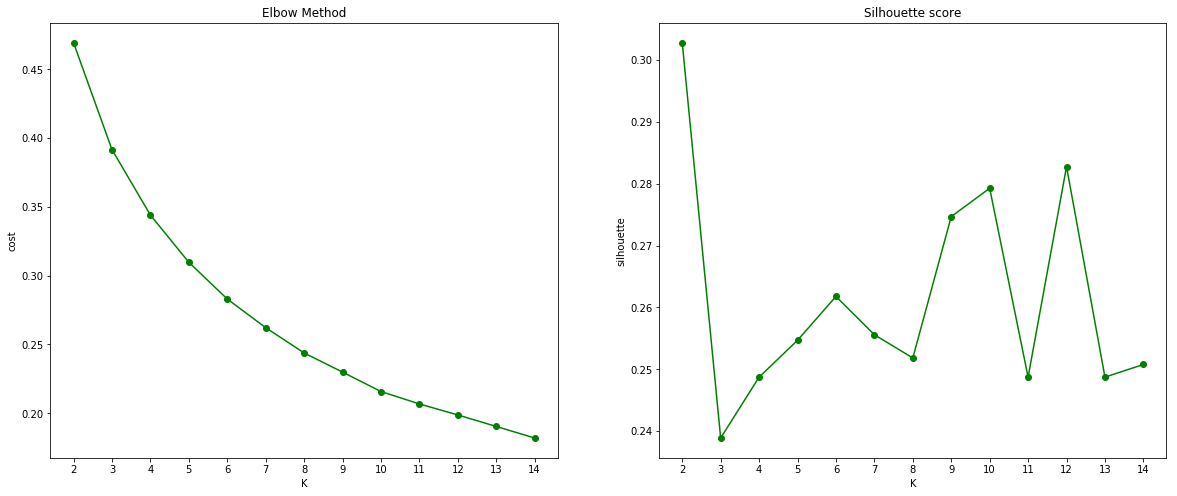

In [12]:
fig, ax = plt.subplots(1, 2, figsize = (20,8))
ax[0].plot(K, cost, 'go-')
ax[0].set_xlabel('K')
ax[0].set_ylabel('cost')
ax[0].set_xticks(K)
ax[0].set_title('Elbow Method')

ax[1].plot(K, sil, 'go-')
ax[1].set_xlabel('K')
ax[1].set_ylabel('silhouette')
ax[1].set_xticks(K)
ax[1].set_title('Silhouette score')

In [14]:
import random
random.seed(310)
km6 = kmeans_missing(subset, n_clusters = 6, weight = np.array([1,1,1,1,1,1,1,1]))
km6.fit(X, max_iter=10000, number_of_runs = 10000, init = 'kmeans++')

In [22]:
df = pd.DataFrame(km6.centroids, columns = cat)
df['size'] = np.unique(km6.labels, return_counts = True)[1]
group = ['EPrepFood', 'ENonFood','ENonFood + Res', 'Partially ECommerce', 'ECommerce Independent', 'ECommerce Dependent']
df.set_index(pd.Index(group), inplace = True)
df.style.background_gradient(subset = cat)

,ChildcareItems,Clothing,Medication,HomeOffice,PreparedFood,OtherFood,PaperCleaning,Groceries,size
EPrepFood,0.185185,0.232537,0.502593,0.0555556,0.664625,0.147205,0.127359,0.0720798,40
ENonFood,0.638889,0.791492,0.775966,0.521296,0.20286,0.0717949,0.0820047,0.0831231,65
ENonFood + Res,0.616667,0.683624,0.116296,0.693326,0.483453,0.0852941,0.327178,0.107186,54
Partially ECommerce,0.676923,0.47376,0.344444,0.454321,0.42643,0.818272,0.373917,0.380657,41
ECommerce Independent,0.459259,0.113475,0.0423611,0.0980392,0.108621,0.0111111,0,0.0352605,80
ECommerce Dependent,0.966223,0.933402,0.860251,0.88836,0.696193,0.702899,0.852707,0.632311,33


In [32]:
dict_ = dict(zip(range(6), group))
sacog_demo['labels']= km6.labels
sacog_demo['labels'] = sacog_demo['labels'].map(dict_)

In [36]:
X_May = sacog_demo[['May-Orders-'+ cat_ for cat_ in cat]]
X_Past = sacog_demo[['PastYear-Orders-'+cat_ for cat_ in cat]]
X_Past = X_Past * (np.mean(X_May).values/np.mean(X_Past).values)
X_Past.columns = cat
X_May.columns = cat

In [37]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_May)
X_May_scaled = scaler.transform(X_May)
X_Past_scaled = scaler.transform(X_Past)
mean_ = pd.DataFrame(X_May_scaled).groupby(sacog_demo.labels).mean()

In [38]:
def Past_Label(row, df_mean):
    if sacog_demo.iloc[row.name]['numkids'] > 0:
        if sum(sacog_demo.iloc[row.name][['PastYear-ECommerce-Frequency-'+cat_ for cat_ in cat]].isin(['Never', 'Almost never'])) > 0:
            return np.sum((row - df_mean[1:])**2, axis = 1).idxmin()
        else:
            return np.sum((row - df_mean)**2, axis = 1).idxmin()
            
    else:
        if sum(sacog_demo.iloc[row.name][['PastYear-ECommerce-Frequency-'+cat_ for cat_ in cat[1:]]].isin(['Never', 'Almost never'])) > 0:
            return np.sum((row[1:] - df_mean[1:][[1,2,3,4,5,6,7]])**2, axis = 1).idxmin()
            #return df_mean[1:].index[np.dot((row - df_mean[1:])**2, np.array(1/df.loc[['Never', 'Almost never']].sum())).argmin()]
        else:
            return np.sum((row[1:] - df_mean[[1,2,3,4,5,6,7]])**2, axis = 1).idxmin()
    #return df_mean.index[np.dot((row - df_mean)**2, np.array(1/df.loc[['Never', 'Almost never']].sum())).argmin()]
    

In [41]:
mean_

,0,1,2,3,4,5,6,7
labels,,,,,,,,
ECommerce Dependent,0.852027,0.392509,0.694509,0.566886,0.553634,0.627668,1.202486,1.249302
ECommerce Independent,-0.148927,-0.471779,-0.540729,-0.378263,-0.558362,-0.364942,-0.422884,-0.335601
ENonFood,-0.118235,0.372701,0.551420,-0.054383,-0.255743,-0.300378,-0.296444,-0.218028
ENonFood + Res,-0.032908,0.329459,-0.462919,0.555875,0.274419,-0.226919,0.129829,-0.197844
EPrepFood,-0.225330,-0.312992,0.258335,-0.419141,0.765216,-0.163503,-0.282303,-0.322481
Partially ECommerce,0.055435,-0.114808,-0.020453,0.044808,-0.058656,1.141479,0.431682,0.570140


In [42]:
def Past_Label(row, df_mean):

    
    if sacog_demo.iloc[row.name]['numkids'] > 0:
        # exclude ECommerce dependent group if never shopped online for any of the category
        if sum(sacog_demo.iloc[row.name][['PastYear-ECommerce-Frequency-'+cat_ for cat_ in cat]].isin(['Never', 'Almost never'])) > 0:
            # exclude Partially ECommerce if never shopped for grocery
            if sum(sacog_demo.iloc[row.name][['PastYear-ECommerce-Frequency-Groceries']].isin(['Never', 'Almost never', 'Less than 1 time per month'])) >0:
                if sum(sacog_demo.iloc[row.name][['PastYear-ECommerce-Frequency-PreparedFood']].isin(['Never', 'Almost never'])) >0:
                    if (sum(sacog_demo.iloc[row.name][['PastYear-ECommerce-Frequency-'+cat_ for cat_ in cat]].isin(['Never', 'Almost never'])) >= 6) & (sum(sacog_demo.iloc[row.name][['PastYear-ECommerce-Frequency-'+cat_ for cat_ in cat]].isin(['Less than 1 time per month'])) >= 1):
                        return 'ECommerce Independent'
                    return np.sum((row - df_mean[1:3])**2, axis = 1).idxmin()
                else:
                    return np.sum((row - df_mean[1:5])**2, axis = 1).idxmin()
            
            else:
                return np.sum((row - df_mean[1:])**2, axis = 1).idxmin()
        else:
            return np.sum((row - df_mean)**2, axis = 1).idxmin()
            
    else:
        if sum(sacog_demo.iloc[row.name][['PastYear-ECommerce-Frequency-'+cat_ for cat_ in cat[1:]]].isin(['Never', 'Almost never'])) > 0:
            if sum(sacog_demo.iloc[row.name][['PastYear-ECommerce-Frequency-Groceries']].isin(['Never', 'Almost never', 'Less than 1 time per month'])) > 0:
                if sum(sacog_demo.iloc[row.name][['PastYear-ECommerce-Frequency-PreparedFood']].isin(['Never', 'Almost never'])) > 0:
                    if (sum(sacog_demo.iloc[row.name][['PastYear-ECommerce-Frequency-'+cat_ for cat_ in cat]].isin(['Never', 'Almost never'])) >= 6) & (sum(sacog_demo.iloc[row.name][['PastYear-ECommerce-Frequency-'+cat_ for cat_ in cat]].isin(['Less than 1 time per month'])) >= 1):
                        return 'ECommerce Independent'
                    return np.sum((row[1:] - df_mean[1:3][[1,2,3,4,5,6,7]])**2, axis = 1).idxmin()
                else:
                    return np.sum((row[1:] - df_mean[1:5][[1,2,3,4,5,6,7]])**2, axis = 1).idxmin()
                
            else:
                return np.sum((row[1:] - df_mean[1:][[1,2,3,4,5,6,7]])**2, axis = 1).idxmin()
            #return np.sum((row[1:] - df_mean[1:][[1,2,3,4,5,6,7]])**2, axis = 1).idxmin()
            
        else:
            return np.sum((row[1:] - df_mean[[1,2,3,4,5,6,7]])**2, axis = 1).idxmin()
    
    

In [39]:
past_label0 = pd.DataFrame(X_Past_scaled).apply(lambda x: Past_Label(x, mean_), axis = 1)
ct = pd.crosstab(past_label0, sacog_demo.labels, margins = True)[['ECommerce Independent', 'EPrepFood', 'ENonFood', 'ENonFood + Res', 'Partially ECommerce', 'ECommerce Dependent', 'All']]
ct.reindex(['ECommerce Independent', 'EPrepFood', 'ENonFood', 'ENonFood + Res', 'Partially ECommerce', 'ECommerce Dependent', 'All'])

labels,ECommerce Independent,EPrepFood,ENonFood,ENonFood + Res,Partially ECommerce,ECommerce Dependent,All
row_0,,,,,,,
ECommerce Independent,46,12,24,20,9,4,115
EPrepFood,5,7,6,4,5,4,31
ENonFood,14,12,24,13,7,10,80
ENonFood + Res,3,2,6,8,6,5,30
Partially ECommerce,8,4,4,8,11,5,40
ECommerce Dependent,4,3,1,1,3,5,17
All,80,40,65,54,41,33,313


In [43]:
past_label0 = pd.DataFrame(X_Past_scaled).apply(lambda x: Past_Label(x, mean_), axis = 1)
ct = pd.crosstab(past_label0, sacog_demo.labels, margins = True)[['ECommerce Independent', 'EPrepFood', 'ENonFood', 'ENonFood + Res', 'Partially ECommerce', 'ECommerce Dependent', 'All']]
ct.reindex(['ECommerce Independent', 'EPrepFood', 'ENonFood', 'ENonFood + Res', 'Partially ECommerce', 'ECommerce Dependent', 'All'])

labels,ECommerce Independent,EPrepFood,ENonFood,ENonFood + Res,Partially ECommerce,ECommerce Dependent,All
row_0,,,,,,,
ECommerce Independent,49,17,29,24,11,4,134
EPrepFood,5,7,6,4,6,4,32
ENonFood,12,10,22,10,9,11,74
ENonFood + Res,3,2,4,9,4,4,26
Partially ECommerce,7,1,3,6,8,5,30
ECommerce Dependent,4,3,1,1,3,5,17
All,80,40,65,54,41,33,313


In [83]:
sacog_demo

['match_id',
 'PersonalIncome',
 'Children-12To18',
 'Children-5To12',
 'Children-Under5',
 'age',
 'May-Employment',
 'May-Employment-Industry',
 'HouseholdIncome',
 'Gender',
 'ethnicity_afam',
 'ethnicity_aiak',
 'ethnicity_asian',
 'ethnicity_hapi',
 'ethnicity_hisp',
 'ethnicity_mideast',
 'ethnicity_multi',
 'ethnicity_noanswer',
 'ethnicity_other',
 'ethnicity_white',
 'Disability-Chronic',
 'Disability-Developmental',
 'Disability-Hearing',
 'Disability-MentalHealth',
 'Disability-None',
 'Disability-Other',
 'Disability-Physical',
 'Disability-Vision',
 'hhveh',
 'numkids',
 'id',
 'Duration (in seconds)',
 'Response ID',
 'May-WorkingHours',
 'May-TelecommutingDays',
 'May-Trips-Commuting',
 'May-Trips-Medical',
 'May-Trips-Gym',
 'May-Trips-ToSchool',
 'May-Trips-FromSchool',
 'May-Trips-Bar',
 'May-Trips-MovieTheater',
 'May-Trips-Friends',
 'May-Trips-Family',
 'May-Trips-Other',
 'May-Trips-OtherType',
 'CommutingFollowup',
 'May-TripDistance-Commuting',
 'May-TripDistanc

In [88]:
sacog_demo[sacog_demo['May-Total-Groceries'] == 0][['May-Portion-E'+cat_ for cat_ in cat]+ ['May-Total-'+cat_ for cat_ in cat]+['labels']+['hhveh', 'PersonalIncome', 'May-Employment', 'age','ethnicity_afam',
        'ethnicity_aiak',
        'ethnicity_asian',
        'ethnicity_hapi',
        'ethnicity_hisp',
        'ethnicity_mideast',
        'ethnicity_multi',
        'ethnicity_noanswer',
        'ethnicity_other',
        'ethnicity_white']]

,May-Portion-EChildcareItems,May-Portion-EClothing,May-Portion-EMedication,May-Portion-EHomeOffice,May-Portion-EPreparedFood,May-Portion-EOtherFood,May-Portion-EPaperCleaning,May-Portion-EGroceries,May-Total-ChildcareItems,May-Total-Clothing,...,ethnicity_afam,ethnicity_aiak,ethnicity_asian,ethnicity_hapi,ethnicity_hisp,ethnicity_mideast,ethnicity_multi,ethnicity_noanswer,ethnicity_other,ethnicity_white
20,NaN,NaN,NaN,NaN,0.666667,0.0,NaN,NaN,0,0,...,0,0,0,0,0,0,0,0,0,1
55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,...,1,0,0,0,0,0,0,0,0,0
57,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0,0,...,0,0,0,0,0,0,0,0,0,1
63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,...,0,0,0,0,0,0,0,0,0,1
127,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,0,0,...,0,0,0,0,1,0,0,0,0,0
296,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,...,0,0,0,0,0,0,0,0,0,1
310,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,...,0,0,0,0,0,0,0,0,0,1


In [87]:
list(sacog_demo.iloc[55])

[56,
 'Prefer not to answer',
 0,
 0,
 0,
 '65 - 74',
 'Retired',
 'No Response',
 'Prefer not to answer',
 'Female',
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 56,
 7264,
 'R_2f7JOFj4jQtRtcs',
 'I did not work from Sunday, May 17th through Saturday, May 23rd',
 -1,
 -9998,
 1,
 -9998,
 -9998,
 -9998,
 -9998,
 -9998,
 -9998,
 -9998,
 -9998,
 nan,
 nan,
 'No Response',
 '1 - 3 miles',
 'No Response',
 'No Response',
 'No Response',
 'No Response',
 'No Response',
 'No Response',
 'No Response',
 'No Response',
 nan,
 'No Response',
 'No Response',
 'No Response',
 'No Response',
 'No Response',
 'No Response',
 'No Response',
 'No Response',
 'No Response',
 'No Response',
 'Drove personal auto with daughter',
 1,
 'No Response',
 0,
 1,
 'Cancer surgery and treatment',
 -9998,
 2,
 -9998,
 -9998,
 -9998,
 -9998,
 -9998,
 -9998,
 -9998,
 -9998,
 nan,
 -9998,
 1,
 -9998,
 -9998,
 -9998,
 -9998,
 -9998,
 -9998,
 -9998,
 -9998,
 nan,
 -9998,
 1,
 -9998

In [46]:
cat1 = [i for i in cat]
cat1.remove('PreparedFood')

In [54]:
sacog_demo[(sacog_demo['May-Portion-EPreparedFood'] >= 0.5) & (sacog_demo[['May-Portion-E'+ cat_ for cat_ in cat1]].isin([np.NaN, 0])).all(1)][['May-Portion-E'+ cat_ for cat_ in cat]]

,May-Portion-EChildcareItems,May-Portion-EClothing,May-Portion-EMedication,May-Portion-EHomeOffice,May-Portion-EPreparedFood,May-Portion-EOtherFood,May-Portion-EPaperCleaning,May-Portion-EGroceries
20,NaN,NaN,NaN,NaN,0.666667,0.0,NaN,NaN
29,NaN,NaN,NaN,NaN,0.500000,NaN,NaN,0.0
48,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,0.0
84,NaN,0.0,NaN,0.0,0.666667,0.0,NaN,0.0
106,NaN,0.0,0.0,NaN,0.666667,0.0,0.0,0.0
114,NaN,NaN,NaN,NaN,0.500000,NaN,0.0,0.0
116,NaN,NaN,NaN,NaN,0.500000,NaN,0.0,0.0
127,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN
133,NaN,0.0,0.0,0.0,1.000000,0.0,0.0,0.0
187,NaN,0.0,0.0,NaN,0.500000,0.0,0.0,0.0


In [55]:
data = sacog_demo.replace(np.NaN, 0)

In [61]:
data[(data['May-Portion-EPreparedFood'] >= 0.5) & (data[['May-Portion-E'+ cat_ for cat_ in cat1]] < 0.3).all(1)][['May-Portion-E'+ cat_ for cat_ in cat]+['labels']+['PastYear-ECommerce-Frequency-'+ cat_ for cat_ in cat]]

,May-Portion-EChildcareItems,May-Portion-EClothing,May-Portion-EMedication,May-Portion-EHomeOffice,May-Portion-EPreparedFood,May-Portion-EOtherFood,May-Portion-EPaperCleaning,May-Portion-EGroceries,labels,PastYear-ECommerce-Frequency-ChildcareItems,PastYear-ECommerce-Frequency-Clothing,PastYear-ECommerce-Frequency-Medication,PastYear-ECommerce-Frequency-HomeOffice,PastYear-ECommerce-Frequency-PreparedFood,PastYear-ECommerce-Frequency-OtherFood,PastYear-ECommerce-Frequency-PaperCleaning,PastYear-ECommerce-Frequency-Groceries
20,0.0,0.0,0.0,0.0,0.666667,0.0,0.0,0.000000,EPrepFood,Never,Never,Never,Never,About 1 time per week,Never,Never,About 1 time per week
29,0.0,0.0,0.0,0.0,0.500000,0.0,0.0,0.000000,ENonFood + Res,Never,Less than 1 time per month,Never,Never,Less than 1 time per week,Never,Never,Never
48,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.000000,EPrepFood,Never,Almost never,Never,Almost never,Never,Never,Never,Never
84,0.0,0.0,0.0,0.0,0.666667,0.0,0.0,0.000000,EPrepFood,Never,Never,Never,Never,About 1 time per week,Never,Never,Never
85,0.0,0.0,0.0,0.0,0.500000,0.0,0.0,0.058824,ECommerce Independent,Never,Never,Never,Never,About 1 time per week,Never,Never,Never
106,0.0,0.0,0.0,0.0,0.666667,0.0,0.0,0.000000,ECommerce Independent,Never,Less than 1 time per week,Less than 1 time per month,Almost never,About 1 time per week,About 1 time per week,Less than 1 time per month,Less than 1 time per week
114,0.0,0.0,0.0,0.0,0.500000,0.0,0.0,0.000000,EPrepFood,Never,Almost never,Never,Never,About 1 time per week,Never,Never,Never
116,0.0,0.0,0.0,0.0,0.500000,0.0,0.0,0.000000,EPrepFood,Never,Less than 1 time per week,Less than 1 time per week,Never,About 1 time per week,Never,Less than 1 time per week,Never
127,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.000000,ECommerce Dependent,Never,Less than 1 time per month,Never,Less than 1 time per month,Less than 1 time per week,Never,Never,Never
133,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.000000,EPrepFood,Never,Less than 1 time per month,Never,Almost never,Never,Less than 1 time per week,Never,Never


In [68]:
data[(~data['PastYear-ECommerce-Frequency-PreparedFood'].isin(['Never', 'Almost never']) & (data[['PastYear-ECommerce-Frequency-'+ cat_ for cat_ in cat1]].isin(['Never', 'Almost never'])).all(1))][['May-Portion-E'+ cat_ for cat_ in cat]+['labels']+['PastYear-ECommerce-Frequency-'+ cat_ for cat_ in cat]]

,May-Portion-EChildcareItems,May-Portion-EClothing,May-Portion-EMedication,May-Portion-EHomeOffice,May-Portion-EPreparedFood,May-Portion-EOtherFood,May-Portion-EPaperCleaning,May-Portion-EGroceries,labels,PastYear-ECommerce-Frequency-ChildcareItems,PastYear-ECommerce-Frequency-Clothing,PastYear-ECommerce-Frequency-Medication,PastYear-ECommerce-Frequency-HomeOffice,PastYear-ECommerce-Frequency-PreparedFood,PastYear-ECommerce-Frequency-OtherFood,PastYear-ECommerce-Frequency-PaperCleaning,PastYear-ECommerce-Frequency-Groceries
7,0.666667,0.0,0.0,0.0,0.500000,0.0,0.0,0.000000,ECommerce Independent,Almost never,Almost never,Never,Never,Less than 1 time per week,Almost never,Never,Almost never
39,0.000000,0.8,0.0,0.0,0.000000,0.0,0.0,0.000000,ENonFood,Never,Almost never,Almost never,Almost never,Less than 1 time per week,Never,Never,Never
54,0.000000,0.0,0.0,0.0,0.333333,1.0,0.0,0.500000,Partially ECommerce,Never,Almost never,Never,Almost never,Less than 1 time per month,Never,Never,Never
59,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,ECommerce Independent,Never,Never,Never,Never,About 1 time per week,Never,Never,Never
84,0.000000,0.0,0.0,0.0,0.666667,0.0,0.0,0.000000,EPrepFood,Never,Never,Never,Never,About 1 time per week,Never,Never,Never
85,0.000000,0.0,0.0,0.0,0.500000,0.0,0.0,0.058824,ECommerce Independent,Never,Never,Never,Never,About 1 time per week,Never,Never,Never
114,0.000000,0.0,0.0,0.0,0.500000,0.0,0.0,0.000000,EPrepFood,Never,Almost never,Never,Never,About 1 time per week,Never,Never,Never
142,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,ECommerce Independent,Never,Almost never,Never,Never,Less than 1 time per month,Never,Never,Never
187,0.000000,0.0,0.0,0.0,0.500000,0.0,0.0,0.000000,ECommerce Independent,Never,Almost never,Never,Almost never,Less than 1 time per month,Never,Never,Never
239,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,ECommerce Independent,Never,Almost never,Never,Almost never,Less than 1 time per month,Almost never,Almost never,Almost never
